Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)
Вспомогательная метрика: MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая.
В файлах не должны содержаться индексы из датафрейма.

Алгоритм
1. Сделать базовую простую модель на базе линейной регрессии

2. Чистка тренировочного dataset:
    - удаление данных в которых нет площади или нет цены
    - корректировка выбросов в данных
    - дополнение отсутствующих данных при необходимости
    - добавление дополнительных признаков таких как средняя цена квадратного метра n-комнатной квартиры в каждом районе
    - выделение категориальных dummy переменных
    - стандартизация признаков
    - определение приоритетных и нужных фич
    - качественное деление dataset на тренировочный и валидационный - kfold stratifier 
    
    - сравнение модели базовой и итоговой
    
3. Работа с тестовым датасетом:
    - работа с данными в которых нет площади или других критических переменных
    - корректировка выбросов в данных
    - дополнение отсутствующих данных при необходимости
    - добавление дополнительных признаков таких как средняя цена квадратного метра n-комнатной квартиры в каждом районе
    - выделение категориальных dummy переменных


In [2858]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # функция разделения массива данных на тренировочные и тестовые
from sklearn.model_selection import StratifiedKFold # функция разделения массива данных на тренировочные и тестовые
from sklearn.model_selection import GridSearchCV # класс для тестирования различных параметров на модели



from sklearn.linear_model import LinearRegression # загрузка класс linear regression
from sklearn.linear_model import Lasso # загрузка класс linear regression
from sklearn.linear_model import Ridge # загрузка класс linear regression

from sklearn.ensemble import RandomForestRegressor # загрузка класс linear regression

from sklearn.metrics import mean_squared_error # среднеквадратичное отклонение
from sklearn.metrics import mean_absolute_error # среднее абсолютное отклонение
from sklearn.metrics import r2_score # Метрика R^2

from sklearn.preprocessing import StandardScaler #класс для стандартизации признаков
from sklearn.preprocessing import RobustScaler #класс для масштабирования признаков

pd.set_option('display.max_columns', 500)


%config inlineBackend.figure_format = 'svg'
%matplotlib inline

In [2859]:
data = pd.read_csv('D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience/Pjt/train.csv')
test_data = pd.read_csv('D:/Personal/Lesha/Data Science & AI/GeekBrains courses/Python/Python for DataScience/Pjt/test.csv')

### Чистка данных тренировочного Dataset

In [2860]:
# Rooms - Коректировка аномальных значений комнат
data.loc[data['Id'].isin([12638, 7917]),'Rooms'] = 4
data.loc[data['Id'].isin([456, 9443]),'Rooms'] = 3
data.loc[data['Id'].isin([5927, 14003, 14865, 770]),'Rooms'] = 2
data.loc[data['Id'].isin([8491, 7594, 6358, 7317, 3159]),'Rooms'] = 1
data.loc[data['Rooms'] == 0,'Rooms'] = data['Rooms'].mode()[0]

In [2861]:
# KitchenSquare - замена площади меньшей чем 5 и большей чем общая площадь квартиры - 8 на среднее значение
mean_kitchen = round(data.loc[(data['KitchenSquare']>4) & (data['Square'] - data['KitchenSquare'] > 8),'KitchenSquare'].mean())
data.loc[(data['Square'] - data['KitchenSquare'] < 8) | (data['KitchenSquare']<5),'KitchenSquare'] = mean_kitchen

In [2862]:
# Square - замена выбросов - наблюдений где Square < 21м и больше 180
data.loc[(data['Square'] < 21) | (data['Square'] > 180),'Square'] = data['Square'].mean()
# lifeSquare - Анамальные значения
data.loc[(data['Square'] - data['KitchenSquare'] - data['LifeSquare'] -5 < 0) |
         (data['LifeSquare'].isnull()),'LifeSquare'] = data['Square'] - data['KitchenSquare'] - 5
data.loc[(data['LifeSquare']<10) & (data['Square']>30),'LifeSquare'] = data['Square'] - data['KitchenSquare'] - 5

In [2863]:
# HouseYear - Анамальные значения
data.loc[data['HouseYear'] == 4968,'HouseYear'] = 1968
data.loc[data['HouseYear'] == 20052011,'HouseYear'] = 2008

In [2864]:
# Healthcare_1 - замена пустых значений на моду
data.loc[data['Healthcare_1'].isnull(),'Healthcare_1'] = data['Healthcare_1'].mode()[0]

In [2865]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,540.0,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,8.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,39.352981,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [2866]:
# Floor & HouseFloor - на цену влияет принадлежность квартиры к первому и последнему этажу
data.loc[data['Id'].isin([9300,10806]),'HouseFloor'] = 9
data.loc[data['Id'].isin([78]),'HouseFloor'] = 17
data.loc[data['HouseFloor'] < data['Floor'],'HouseFloor'] = data['Floor'] + 1

### Дополнительные переменные

In [2867]:
# добавление фактической стоимости метра квадратного
data['M_Price'] = data['Price'] / data['Square']

In [2868]:
# добавляем среднюю стоимость метра квадратного в районе в зависимости от размера квартиры (комнатности)

# расчет будет производится без учета выбросов данных по общей площади
data1 = data.drop(data.loc[(data['Square'] < 21)].index)
#data1 = data.drop(data.loc[(data['Square'] < 21) | (data['Square'] > 160)].index)

m_price_by_district = data1.groupby(['DistrictId','Rooms']).agg({'M_Price':['count','min','max', 'mean','median']}).reset_index()
m_price_by_district = pd.DataFrame({'DistrictId':m_price_by_district['DistrictId'],
                                    'Rooms':m_price_by_district['Rooms'],
                                    'M_Price_district_mean':m_price_by_district[('M_Price', 'mean')]})
data = pd.merge(data, m_price_by_district, how='left',on=['DistrictId','Rooms'])
m_price_mean = data['M_Price'].mean()
data.loc[data['M_Price_district_mean'].isnull(),'M_Price_district_mean'] = m_price_mean

In [2869]:
# добавление оценку стоимости квартиры на основании средней стоимости метра квадратного
data['Price_mean'] = data['M_Price_district_mean'] * data['Square'] 

In [2870]:
# HousePeriod - Распределение квартир по периодам застройки на основании года постройки дома

def define_HouseYear_period(HouseYear_periods, HouseYear):
    for i in range(len(HouseYear_periods)-1):
        if HouseYear >= HouseYear_periods[i] and HouseYear <= HouseYear_periods[i+1]:
                return (str(HouseYear_periods[i]) + ' - ' +  str(HouseYear_periods[i+1])) 

#HouseYear_periods = np.linspace(data['HouseYear'].min(), data['HouseYear'].max(),11).round().astype(int)    
HouseYear_periods = [1910, 1920, 1932, 1954, 1965, 1987, 1998, 2009, 2018, 2020]

data['HousePeriod'] = data['HouseYear'].apply(lambda x: define_HouseYear_period(HouseYear_periods, x))

In [2871]:
# Добавление переменной - первый / последний этаж
data['first_floor'] = 0
data['last_floor'] = 0
data.loc[(data['Floor']==1) ,'first_floor'] = 1
data.loc[(data['Floor']==data['HouseFloor']) ,'last_floor'] = 1
#data.loc[(data['Floor']==1) | (data['Floor'] == data['HouseFloor']) ,'first_last_floor'] = 1

In [2872]:
data = data.set_index(data['Id']).drop('Id', axis=1)

In [2873]:
data.loc[data['Ecology_2'] =='A', 'Ecology_2'] = 1
data.loc[data['Ecology_2'] =='B', 'Ecology_2'] = 0

data.loc[data['Ecology_3'] =='A', 'Ecology_3'] = 1
data.loc[data['Ecology_3'] =='B', 'Ecology_3'] = 0

data.loc[data['Shops_2'] =='A', 'Shops_2'] = 1
data.loc[data['Shops_2'] =='B', 'Shops_2'] = 0

In [2874]:
# Dummy переменные
data['Helthcare_2'] = data['Helthcare_2'].astype('category')
data = pd.get_dummies(data)

In [2875]:
# Эксперементальные переменные
data['k1'] = data['Square']**2
data['k2'] = 1 / (data['Square'])
data['k3'] = 1 / (data['M_Price_district_mean'])
data['k4'] = (data['M_Price_district_mean']) ** 2

In [2876]:
# Стандартизация входных параметров
cols = ['Rooms', 'Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3','Healthcare_1','Shops_1','M_Price_district_mean','Price_mean','k1','k2','k3','k4']
scaler = StandardScaler()
data[cols] = scaler.fit_transform(data[cols])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Модель Линейной регрессии

In [2877]:
# Разделение данных на тестовые и валидационные
X = data.drop(['DistrictId','Price', 'LifeSquare','M_Price', 'HouseYear', 'M_Price_district_mean'], axis=1)
X = X.drop(['Shops_1'], axis=1)
X = X.drop(['Shops_2'], axis=1)
X = X.drop(['Ecology_2'], axis=1)
X = X.drop(['Ecology_3'], axis=1)
X = X.drop(['Social_1'], axis=1)
#X = X.drop(['Social_2'], axis=1)
X = X.drop(['Social_3'], axis=1)
X = X.drop(['Helthcare_2_1', 'Helthcare_2_2', 'Helthcare_2_4','Helthcare_2_5','Helthcare_2_6',], axis=1)
y = data['Price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state =42)

In [2878]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [2879]:
y_pred = model.predict(X_valid)
y_error = y_valid - y_pred
check_test = pd.DataFrame({'y_valid':y_valid, 'y_pred':y_pred, 'y_error':y_error}, index=y_valid.index)
model_results = pd.DataFrame({'Features': X_valid.columns, 'Coef':model.coef_.flatten()})

# Метрики качеств модели
print('Cреднеквадратичное отклонение: ', mean_squared_error(y_valid, y_pred))
print('Cреднее абсолютное отклонение: ', mean_absolute_error(y_valid, y_pred))
print('R2 отклонение:                ', r2_score(y_valid, y_pred))

Cреднеквадратичное отклонение:  2126344417.2868588
Cреднее абсолютное отклонение:  28368.653452721544
R2 отклонение:                 0.7528010949889754


<BarContainer object of 26 artists>

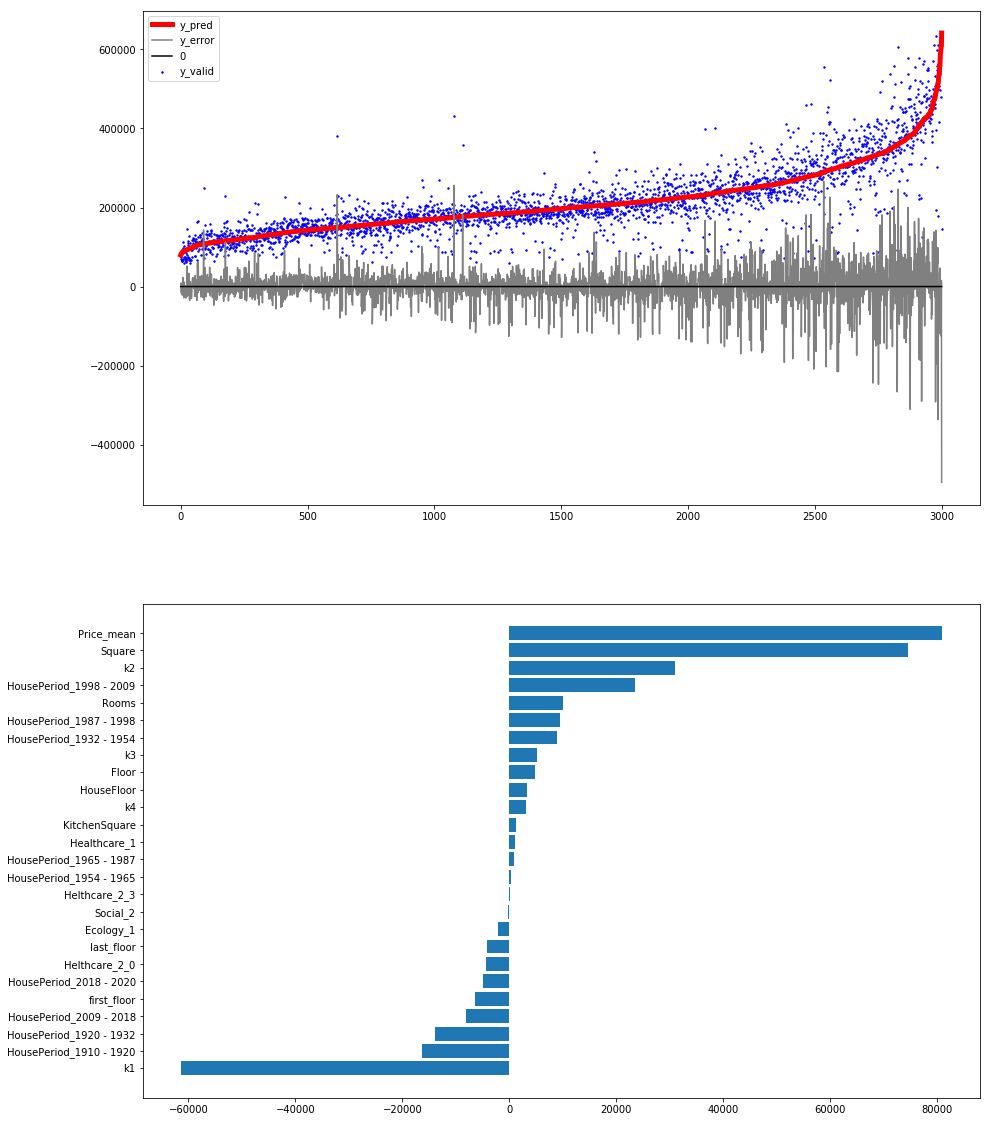

In [2880]:
# Визуализация полуенных результатов
fig, ax = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(15,20)
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax = ax.flatten()
ax[0].scatter(range(y_valid.count()), check_test.sort_values(by='y_pred')['y_valid'], label='y_valid', s=2, color='blue')
ax[0].plot(range(y_valid.count()), check_test.sort_values(by='y_pred')['y_pred'], label='y_pred', color='red',linewidth=5)
ax[0].plot(range(y_valid.count()), check_test.sort_values(by='y_pred')['y_error'], label='y_error', color='grey')

ax[0].plot(range(y_valid.count()), [0 for i in range(len(check_test))], label='0', color='black')
ax[0].legend()

ax[1].barh(model_results.sort_values(by='Coef')['Features'], model_results.sort_values(by='Coef')['Coef'])

In [2881]:
model_test = []
for i in range(1000):
    y = data['Price']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=i)
    y_pred = model.predict(X_valid)
    model_test.append([i, mean_squared_error(y_valid, y_pred), mean_absolute_error(y_valid, y_pred), r2_score(y_valid, y_pred)])
model_test = pd.DataFrame(model_test, columns=['random_state','mean_squared_error','mean_absolut_error','r2_score'])
print(model_test['r2_score'].mean())
print(model_test['r2_score'].std())

0.7651881242577021
0.01200877965321661


(array([  4.,   4.,   8.,  22.,  52., 112., 143., 184., 175., 130.,  86.,
         46.,  24.,   6.,   4.]),
 array([0.72283165, 0.7282183 , 0.73360496, 0.73899161, 0.74437827,
        0.74976493, 0.75515158, 0.76053824, 0.76592489, 0.77131155,
        0.77669821, 0.78208486, 0.78747152, 0.79285818, 0.79824483,
        0.80363149]),
 <a list of 15 Patch objects>)

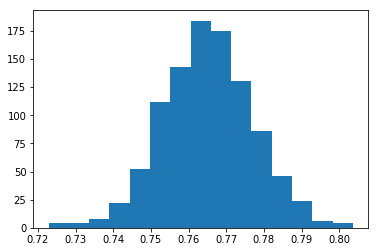

In [2882]:
plt.hist(model_test['r2_score'],bins=15)

### Модель RandomForestRegression

In [2883]:
# Разделение данных на тестовые и валидационные
X = data.drop(['DistrictId','Price', 'M_Price', 'HouseYear'], axis=1)
#X = X.drop(['Shops_1'], axis=1)
#X = X.drop(['Shops_2'], axis=1)
#X = X.drop(['Ecology_2'], axis=1)
#X = X.drop(['Ecology_3'], axis=1)
#X = X.drop(['Social_1'], axis=1)
#X = X.drop(['Social_2'], axis=1)
#X = X.drop(['Social_3'], axis=1)
#X = X.drop(['Helthcare_2_1', 'Helthcare_2_2', 'Helthcare_2_4','Helthcare_2_5','Helthcare_2_6',], axis=1)

y = data['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state = 42)

In [2884]:
# Определение оптимальных параметров модели
parameters =  [{'n_estimators': [100], 'max_features': [5], 'max_depth': np.arange(8, 15)}]
#model = RandomForestRegressor(n_estimators = 20, max_depth = 12, random_state = 42)
models = GridSearchCV(estimator = RandomForestRegressor(random_state=42), param_grid=parameters, cv=3)
models.fit(X_train, y_train)
models.best_params_

{'max_depth': 12, 'max_features': 5, 'n_estimators': 100}

In [2885]:
# Метрики качества модели при базовом кол-ве n_estimators - 100
y_pred = models.predict(X_valid)
print('Cреднеквадратичное отклонение: ', mean_squared_error(y_valid, y_pred))
print('Cреднее абсолютное отклонение: ', mean_absolute_error(y_valid, y_pred))
print('R2 отклонение:                ', r2_score(y_valid, y_pred))

Cреднеквадратичное отклонение:  1990947741.4139576
Cреднее абсолютное отклонение:  26658.659046143985
R2 отклонение:                 0.7685416823302399


In [2886]:
# Построение модели на основании оптимальных параметров c n_estimators = 1000
model = RandomForestRegressor(n_estimators = 1000, 
                              max_depth = models.best_params_['max_depth'], 
                              max_features=models.best_params_['max_features'], 
                              random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=None, oob_score=False,
           random_state=42, verbose=0, warm_start=False)

In [2887]:
# Построение прогноза на базе модели
y_pred = model.predict(X_valid)
y_error = y_valid - y_pred
check_test = pd.DataFrame({'y_valid':y_valid, 'y_pred':y_pred, 'y_error':y_error}, index=y_valid.index)
model_results = pd.DataFrame({'Features': X_valid.columns, 'Coef':model.feature_importances_.flatten()})

# Метрики качества модели
print('Cреднеквадратичное отклонение: ', mean_squared_error(y_valid, y_pred))
print('Cреднее абсолютное отклонение: ', mean_absolute_error(y_valid, y_pred))
print('R2 отклонение:                ', r2_score(y_valid, y_pred))

Cреднеквадратичное отклонение:  1960244721.009638
Cреднее абсолютное отклонение:  26470.84669615109
R2 отклонение:                 0.7721110725770763


<BarContainer object of 39 artists>

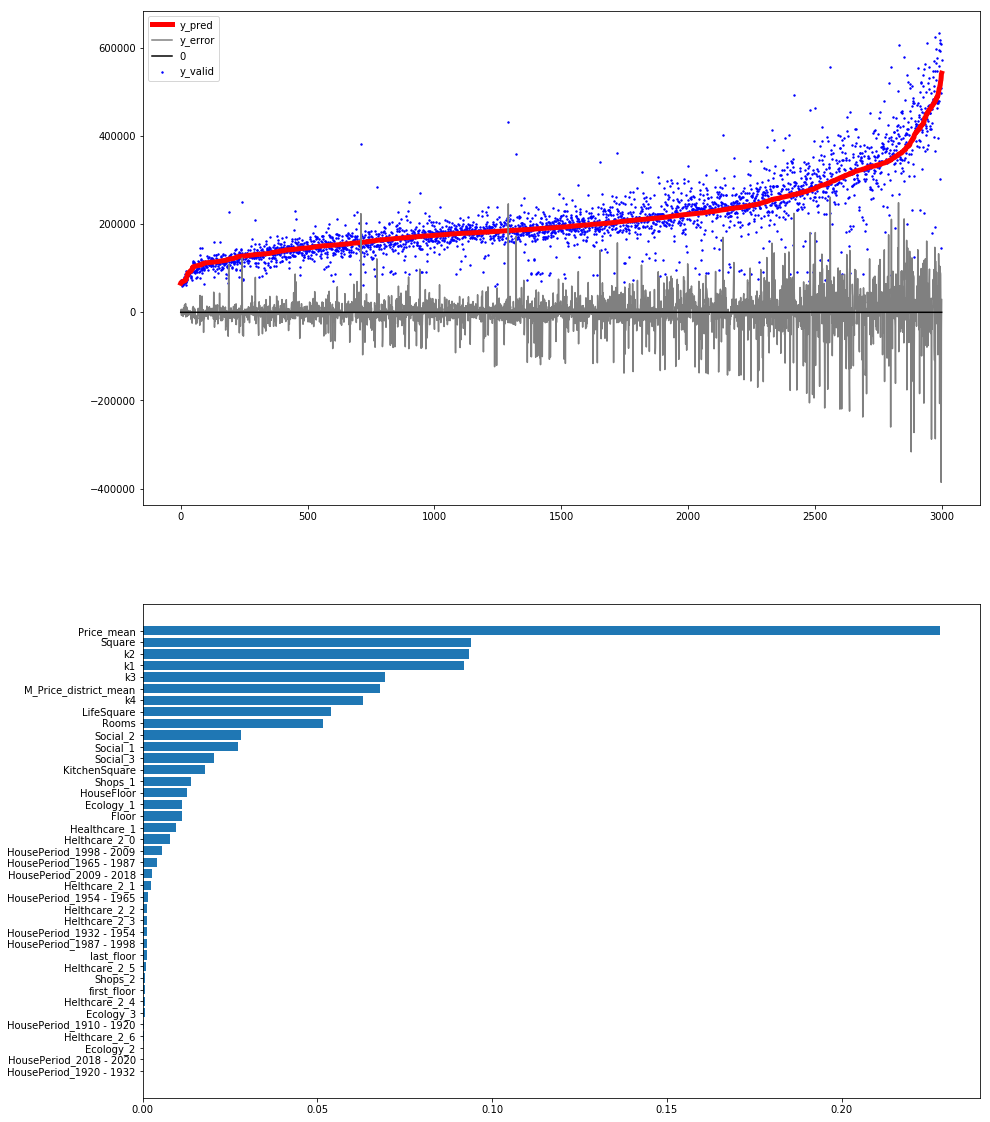

In [2888]:
# Визуализация полуенных результатов
fig, ax = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(15,20)
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax = ax.flatten()
ax[0].scatter(range(y_valid.count()), check_test.sort_values(by='y_pred')['y_valid'], label='y_valid', s=2, color='blue')
ax[0].plot(range(y_valid.count()), check_test.sort_values(by='y_pred')['y_pred'], label='y_pred', color='red',linewidth=5)
ax[0].plot(range(y_valid.count()), check_test.sort_values(by='y_pred')['y_error'], label='y_error', color='grey')

ax[0].plot(range(y_valid.count()), [0 for i in range(len(check_test))], label='0', color='black')
ax[0].legend()

ax[1].barh(model_results.sort_values(by='Coef')['Features'], model_results.sort_values(by='Coef')['Coef'])

In [2889]:
model_test = []
for i in range(500):
    y = data['Price']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=i)
    y_pred = model.predict(X_valid)
    model_test.append([i, mean_squared_error(y_valid, y_pred), mean_absolute_error(y_valid, y_pred), r2_score(y_valid, y_pred)])
model_test = pd.DataFrame(model_test, columns=['random_state','mean_squared_error','mean_absolut_error','r2_score'])
print(model_test['r2_score'].mean())

0.8713856311158356


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  29.,
        113., 197., 135.,  24.]),
 array([0.77211107, 0.78005734, 0.78800361, 0.79594988, 0.80389614,
        0.81184241, 0.81978868, 0.82773495, 0.83568121, 0.84362748,
        0.85157375, 0.85952002, 0.86746628, 0.87541255, 0.88335882,
        0.89130509]),
 <a list of 15 Patch objects>)

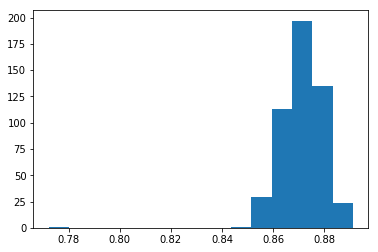

In [2890]:
plt.hist(model_test['r2_score'], bins=15)

In [2891]:
# Square - Аномальные значения
#data.loc[data['Id'].isin([11602,28,2307]),'Square'] = data['Square'] / 10 # корректировка аномального значения
#data.loc[data['Id'].isin([11602,28,2307]),'LifeSquare'] = data['LifeSquare'] / 10 # корректировка аномального значения

#mean_square= list(range(data['Rooms'].nunique()+1))
#mean_square[0] = data['Square'].mean()
#for i in range(1, data['Rooms'].nunique()+1):
#    mean_square[i] = round(data.loc[data['Rooms'] == i,'Square'].mean())   
#print('Средняя площадь:', mean_square[1:])

#def define_rooms(mean_square_list, square):
#    mean_square_list = np.array(mean_square_list)
#    return list(abs(mean_square_list - square)).index(min(abs((mean_square_list - square)))) + 1

# Healthcare_1 - замена пустых значений на моду (сначала заменяются на моды по району, а если такой нет то на моду по датасету)
#HC_1 = data.groupby('DistrictId')['Healthcare_1'].apply(lambda x: x.mode())
#HC_1 = HC_1.reset_index()
#HC_1 = HC_1.drop(HC_1.loc[HC_1['level_1'] > 0,:].index)
#HC_1 = HC_1.drop('level_1', axis=1)
#HC_1 = HC_1.rename(columns={'Healthcare_1':'Healthcare_1_NEW'})
#data = pd.merge(data, HC_1, how='left', on='DistrictId')
#data.loc[data['Healthcare_1'].isnull(),'Healthcare_1'] = data['Healthcare_1_NEW']
#data.drop('Healthcare_1_NEW', axis=1, inplace=True)